In [1]:
from functools import partial
from fvhoe.hydro import advection_dt
from fvhoe.initial_conditions import square
from fvhoe.solver import EulerSolver
import matplotlib.pyplot as plt

In [2]:
# import sd code
import sys

sys.path.append("/home/jp7427/Desktop/spd/src")
sys.path.append("/home/jp7427/Desktop/spd/utils")

import initial_conditions as ic
from sdader_simulator import SDADER_Simulator
import visualization as vsd

In [3]:
N = 64
p = 1
n_iterations = 10
cupy = False

100%|██████████| 10/10 [00:00<00:00, 42.73it/s]

fv.step_count=10
fv.execution_time=0.24061965942382812


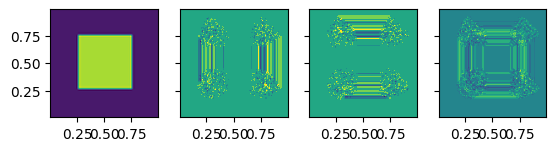

In [4]:
fv = EulerSolver(
    w0=partial(square, dims="xy", vx=1, vy=1),
    nx=N * (p + 1),
    ny=N * (p + 1),
    px=p,
    py=p,
    CFL=0.6,
    cupy=cupy,
)
fv.rkorder(n=n_iterations)

print(f"{fv.step_count=}")
print(f"{fv.execution_time=}")

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fv.plot_2d_slice(axs[0], param="rho", cmap="viridis", verbose=False)
fv.plot_2d_slice(axs[1], param="vx", cmap="viridis", verbose=False)
fv.plot_2d_slice(axs[2], param="vy", cmap="viridis", verbose=False)
fv.plot_2d_slice(axs[3], param="P", cmap="viridis", verbose=False)

t=0.010735309958198621, steps taken 10, time taken 0.46849292679689825
sd.n_step * (p+1)=20
sd.execution_time=0.46849292679689825


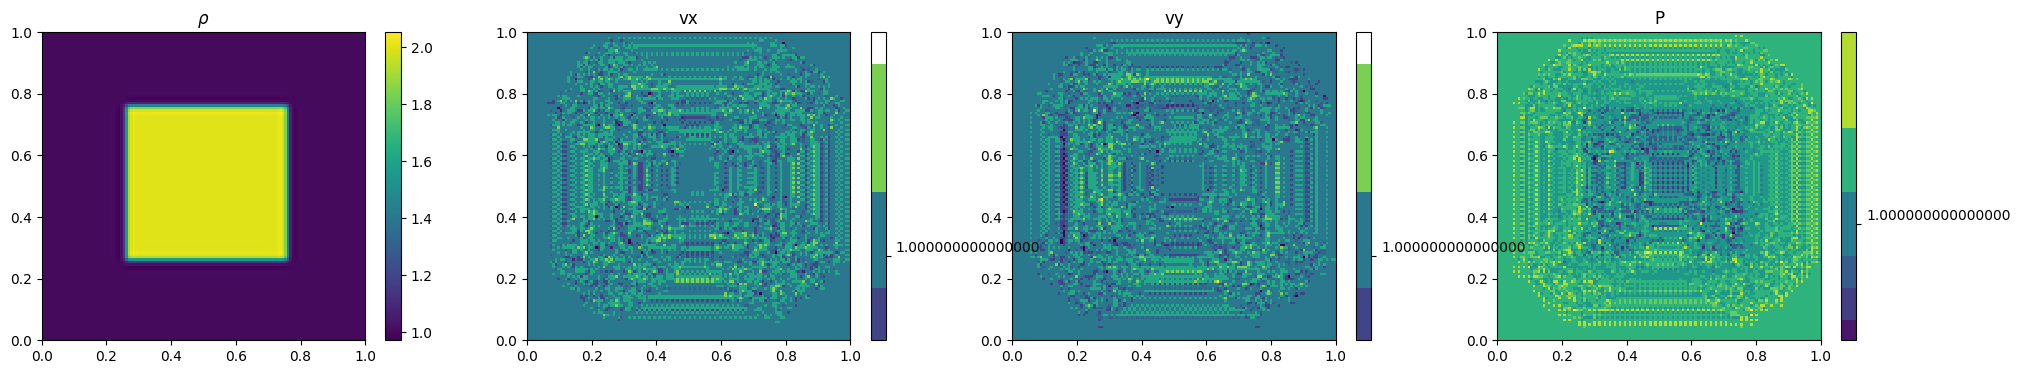

In [5]:
sd = SDADER_Simulator(
    p=p,
    N=(N, N),
    init_fct=ic.step_function(),
    cfl_coeff=0.6,
    update="SD",
    use_cupy=cupy,
)
sd.perform_iterations(n_iterations)

print(f"{sd.n_step * (p+1)=}")
print(f"{sd.execution_time=}")

vsd.plot_fields(sd, sd.dm.W_cv)